In [189]:
%matplotlib inline

import os
import json
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='Arial')


import matplotlib.font_manager as fm

path = '/Users/ShinAhnjae/Library/Fonts/NanumBarunGothicBold.otf'
fontprop = fm.FontProperties(fname=path, size=30)

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'AppleGothic'
plt.rcParams['font.size'] = 30.
plt.rcParams['xtick.labelsize'] = 24.
plt.rcParams['ytick.labelsize'] = 24.
plt.rcParams['axes.labelsize'] = 20.

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from datetime import datetime


def drop_cols(df, cols):
    for col in cols:
        if col in df.columns:
            df = df.drop(col, axis=1)
    return df

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, leaf_font_size=25)

In [175]:
subway_list_df = pd.read_csv('./gendata/subway/list_interest.csv')
subway_list_df = subway_list_df.dropna(axis=0)
subway_list_df = subway_list_df[subway_list_df['address'].str.contains("서울")]
subway_list_df = subway_list_df.set_index(subway_list_df.code)
subway_list_df = subway_list_df.set_index(subway_list_df.code)
subway_list_df = subway_list_df.drop_duplicates(subset=['code'])
subway_people_df = pd.read_csv('./gendata/subway/in_out_by_date.csv')
subway_people_df = subway_people_df.drop('Unnamed: 0', axis=1)
subway_people_df = subway_people_df.drop('line', axis=1)
# subway_people_df = subway_people_df.drop('code', axis=1)
subway_people_df = subway_people_df.drop('name', axis=1)
subway_people_df = subway_people_df.set_index(subway_people_df['code'])
subway_people_df.date = subway_people_df.date.apply(str)
subway_people_df = subway_people_df[subway_people_df['date'].str.match(r'20\d\d122[45]')]

subway_people_df = subway_people_df.join(subway_list_df, how='inner', lsuffix='_left', rsuffix='_right')
subway_people_df = subway_people_df.drop('code_left', axis=1)
subway_people_df = subway_people_df.drop('code_right', axis=1)
subway_people_df = subway_people_df.drop('out_code', axis=1)
subway_people_df = subway_people_df.drop('eng_name', axis=1)
# subway_people_df = subway_people_df.query('in_people >= 15000 or out_people >= 15000')
subway_people_df.to_csv('./gendata/subway/people_joined.csv')

subway_people_df = subway_people_df.reset_index()

subway_places = pd.read_csv('./gendata/subway/places.csv')
subway_places = subway_places.drop('Unnamed: 0', axis=1)
subway_places = subway_places.drop('famous_exit', axis=1)
subway_places = subway_places.dropna(axis=0)
subway_places = subway_places.set_index(subway_places.code)
subway_places = subway_places.join(subway_list_df, how='inner', lsuffix='_left', rsuffix='_right')
subway_places = subway_places.drop('code_left', axis=1)
subway_places = subway_places.drop('code_right', axis=1)
subway_places = subway_places.drop('out_code', axis=1)
subway_places = subway_places.drop('eng_name', axis=1)
subway_places.to_csv('./gendata/subway/place_joined.csv')
subway_people_df.head()

for name, group in subway_people_df.groupby(['name', 'date']):
    ip_sum = group.in_people.sum()
    op_sum = group.out_people.sum()
    for idx in group.index:
        subway_people_df.at[idx, 'in_people'] = ip_sum
        subway_people_df.at[idx, 'out_people'] = op_sum

drop_list = []
THRESHOLD = 15000
for name, group in subway_people_df.groupby(['name']):    
    ip = group.in_people >= THRESHOLD
    op = group.out_people >= THRESHOLD
    if (not ip.any()) and (not op.any()):
        drop_list.append(name)
for drop_station in drop_list:
    subway_people_df = subway_people_df[subway_people_df['name'] != drop_station]
subway_people_df.head()
print(len(subway_people_df))
subway_people_df.to_csv('./gendata/subway/people_joined_2.csv')

1119


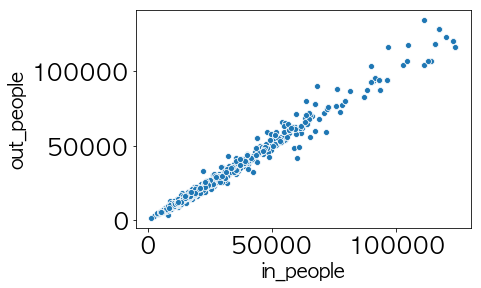

In [176]:
sns.scatterplot(x="in_people", y="out_people", data=subway_people_df)

In [177]:
subway_people_df = subway_people_df.drop_duplicates(subset=['date', 'name'])
subway_people_df = subway_people_df.drop('line', axis=1)
subway_people_df = subway_people_df.drop('address', axis=1)
subway_people_df.head()

,code,date,in_people,out_people,name,x,y
0,150,20151224,90605.0,93632.0,서울역,126.972091,37.55598
1,150,20151225,64761.0,71633.0,서울역,126.972091,37.55598
2,150,20161224,72217.0,74464.0,서울역,126.972091,37.55598
3,150,20161225,53634.0,55970.0,서울역,126.972091,37.55598
4,150,20171224,49441.0,58016.0,서울역,126.972091,37.55598


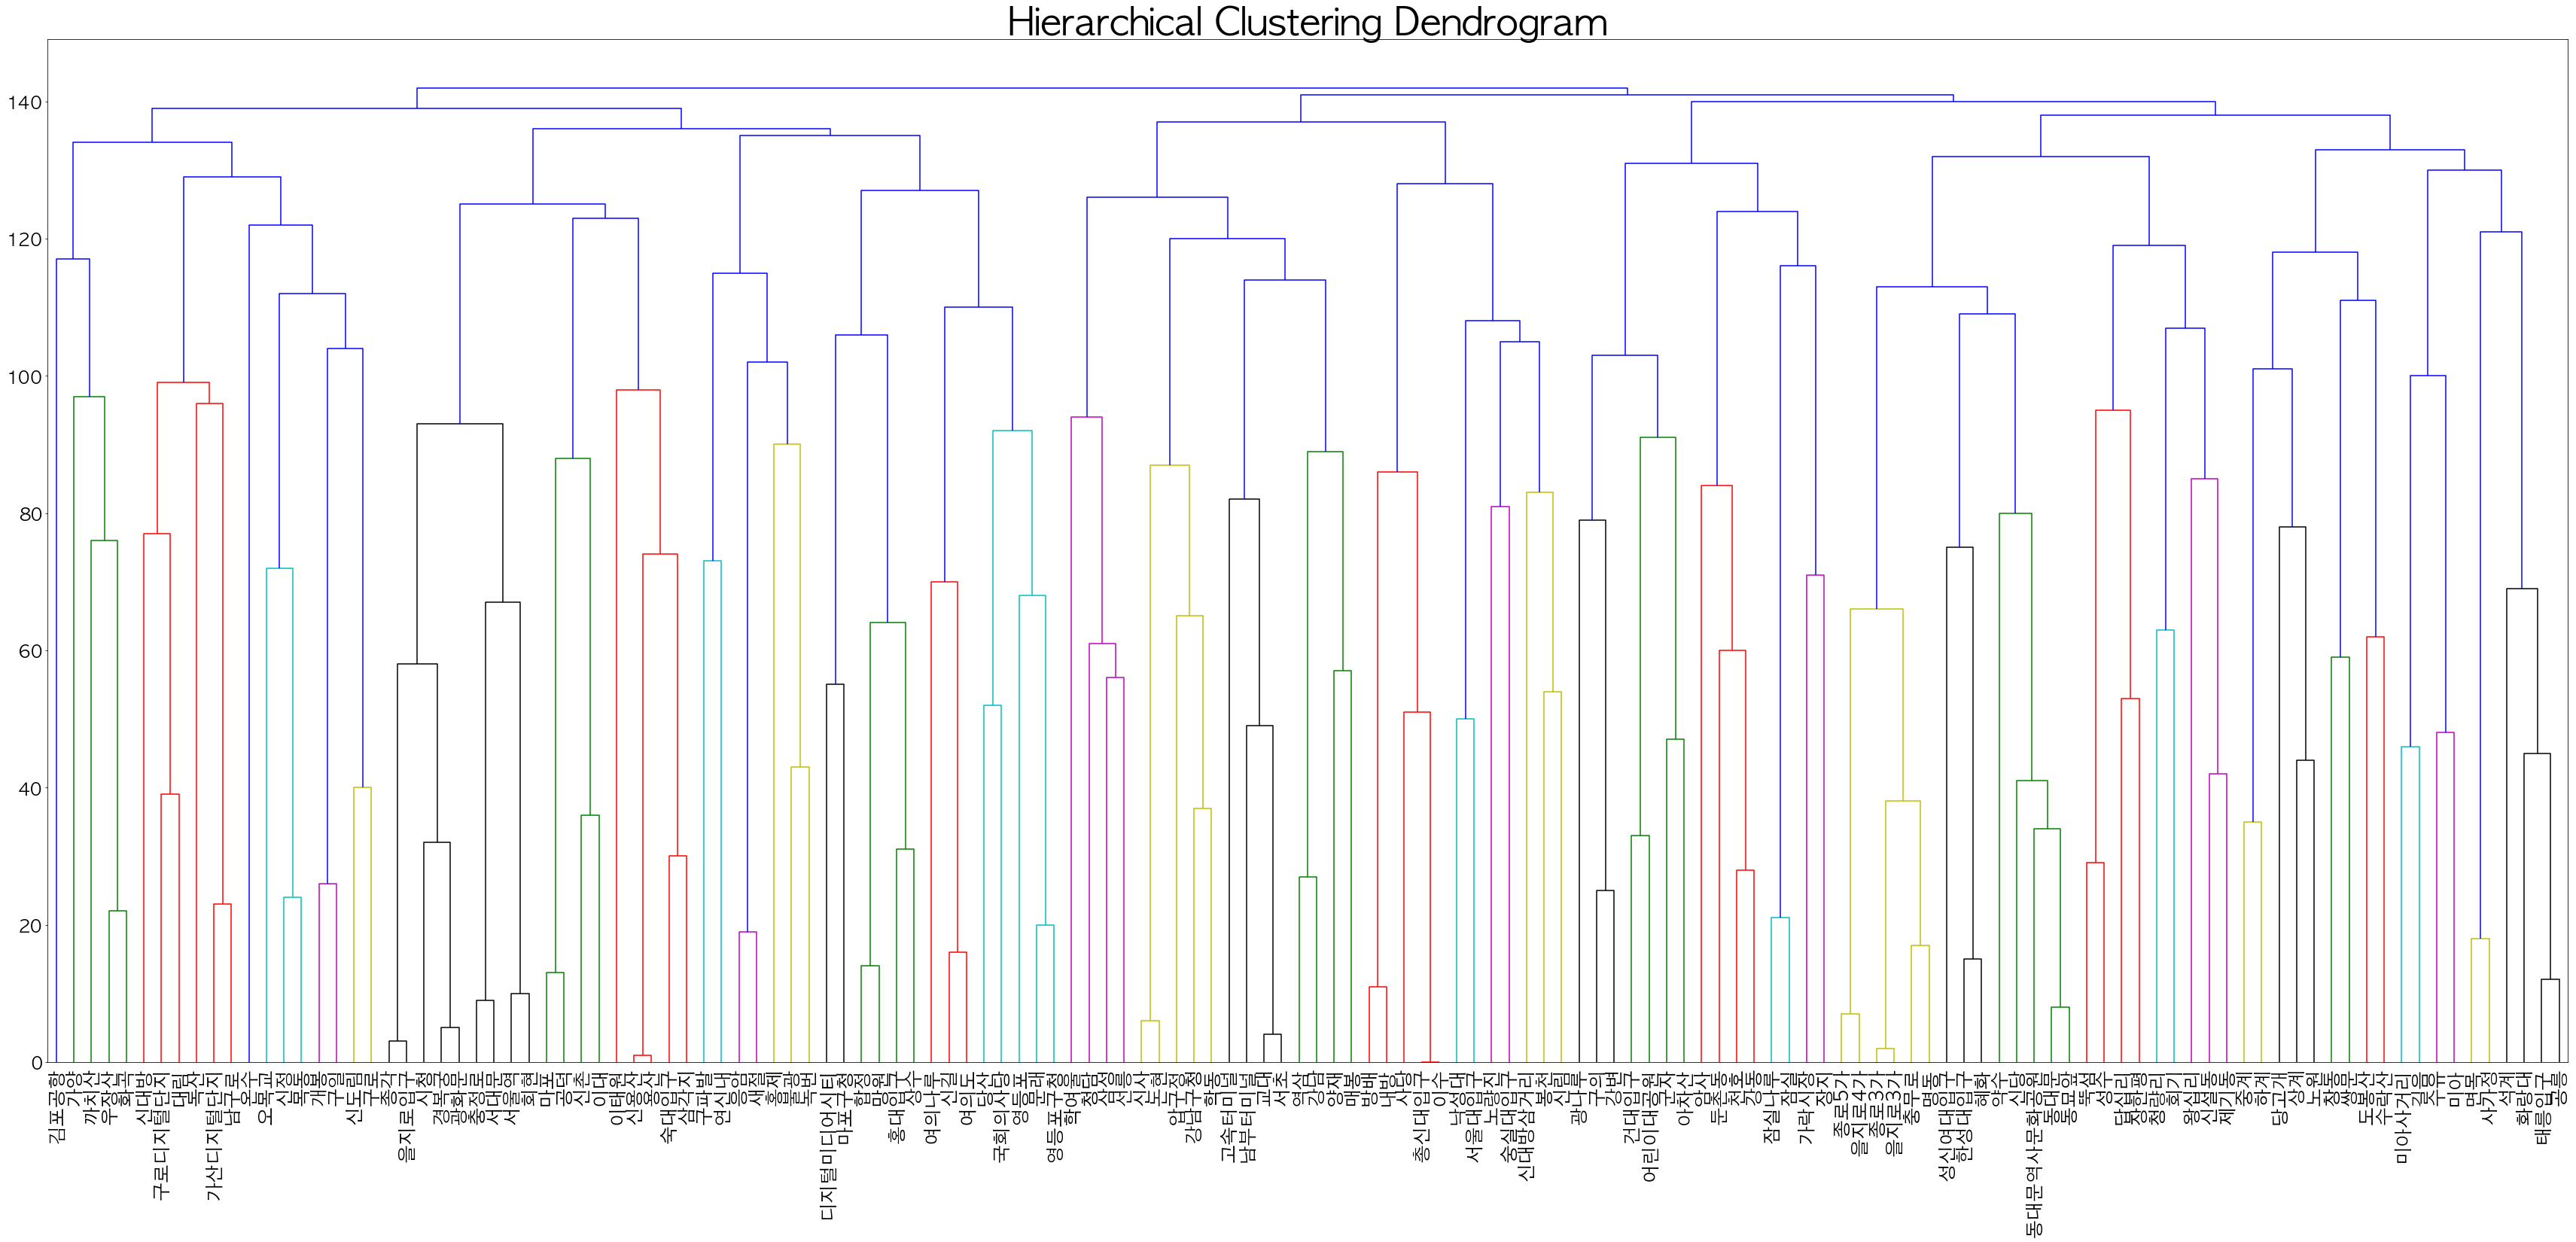

<Figure size 432x288 with 0 Axes>

In [178]:
model = AgglomerativeClustering(n_clusters=100)

fig = plt.figure(figsize=(60, 25))
model = model.fit(subway_ls_df[['x', 'y']])
plt.title('Hierarchical Clustering Dendrogram')
plt.rcParams.update({'font.size': 42})
plot_dendrogram(model, labels=subway_ls_df.name.values.tolist())
plt.show()
plt.savefig('./gendata/subway/cluster.png')

In [186]:
def save_cluster_merge_subsets(subway_people_df, n_clusters=80):
    subway_ls_df = subway_people_df[['name', 'x', 'y']]
    subway_ls_df = subway_ls_df.drop_duplicates(subset=['name'])
#     print(len(subway_ls_df))
    subway_ls_df.head()

#     n_clusters = 80
    group_name = 'group_{}'.format(n_clusters)
    print(group_name)

    def cluster_stations(n_clusters):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        model = model.fit(subway_ls_df[['x', 'y']])
        return model
    model = cluster_stations(n_clusters)
    subway_ls_df[group_name] = model.labels_

    subway_people_df = subway_people_df.set_index(subway_people_df.name)
    subway_people_df = subway_people_df.drop('name', axis=1)
    subway_ls_df = subway_ls_df.set_index(subway_ls_df.name)
    subway_ls_df = subway_ls_df.drop('name', axis=1)

    subway_people_merge_df = subway_people_df.join(subway_ls_df[[group_name]], how='inner', lsuffix='_left', rsuffix='_right')
    # subway_people_merge_df = drop_cols(subway_people_merge_df, ['group_30'])

    subway_people_df = subway_people_df.reset_index()
    subway_ls_df = subway_ls_df.reset_index()
    subway_people_merge_df = subway_people_merge_df.reset_index()

    subway_merged_df = pd.DataFrame(columns=['x', 'y', 'stations', 'date', 'in_people', 'out_people'])
    for idx, group in subway_people_merge_df.groupby([group_name, 'date']):
        x_mean = group.x.mean()
        y_mean = group.y.mean()
        ip_sum = group.in_people.sum()
        op_sum = group.out_people.sum()
        stations = group.name.values
        date = idx[1]
        row = {
            'x': x_mean, 'y': y_mean, 'stations': stations, 'in_people': ip_sum, 'out_people': op_sum,
            'date': date
        }
        subway_merged_df = subway_merged_df.append(row, ignore_index=True)
    subway_merged_df
    subway_merged_df.to_csv('./gendata/subway/people_join_merged_{}.csv'.format(n_clusters))

In [187]:
for i in range(5, 130, 5):
    save_cluster_merge_subsets(subway_people_df, i)

group_5
group_10
group_15
group_20
group_25
group_30
group_35
group_40
group_45
group_50
group_55
group_60
group_65
group_70
group_75
group_80
group_85
group_90
group_95
group_100
group_105
group_110
group_115
group_120
group_125


In [133]:
subway_merged_df['people'] = subway_merged_df.apply(lambda r: r['in_people'] + r['out_people'], axis=1)

In [141]:
for idx, group in subway_merged_df.groupby('date'):
    g = group.sort_values('people', ascending=False)
    for rank, (idx, row) in enumerate(g.iterrows()):
        subway_merged_df.at[idx, 'rank'] = rank + 1
#         print(rank, idx)
subway_merged_df

,x,y,stations,date,in_people,out_people,people,rank
0,127.050563,37.588099,"[청량리, 회기]",20151224,69792.0,69855.0,139647.0,27.0
1,127.050563,37.588099,"[청량리, 회기]",20151225,52796.0,53351.0,106147.0,24.0
2,127.050563,37.588099,"[청량리, 회기]",20161224,58172.0,57862.0,116034.0,25.0
3,127.050563,37.588099,"[청량리, 회기]",20161225,44495.0,44456.0,88951.0,24.0
4,127.050563,37.588099,"[청량리, 회기]",20171224,41935.0,42320.0,84255.0,25.0
5,127.050563,37.588099,"[청량리, 회기]",20171225,43428.0,44325.0,87753.0,25.0
6,127.054547,37.510938,"[삼성, 선릉, 청담]",20151224,169410.0,162067.0,331477.0,4.0
7,127.054547,37.510938,"[삼성, 선릉, 청담]",20151225,70197.0,71314.0,141511.0,14.0
8,127.054547,37.510938,"[삼성, 선릉, 청담]",20161224,95409.0,94689.0,190098.0,10.0
9,127.054547,37.510938,"[삼성, 선릉, 청담]",20161225,66678.0,66585.0,133263.0,12.0


In [142]:
subway_merged_df.to_csv('./gendata/subway/people_join_merged_{}.csv'.format(n_clusters))

       date  in_people  out_people
0  20151224  5175884.0   5220964.0
1  20151225  3305293.0   3325698.0
2  20161224  3903804.0   3939873.0
3  20161225  2854932.0   2851499.0
4  20171224  2821328.0   2852947.0
5  20171225  2991042.0   2994029.0


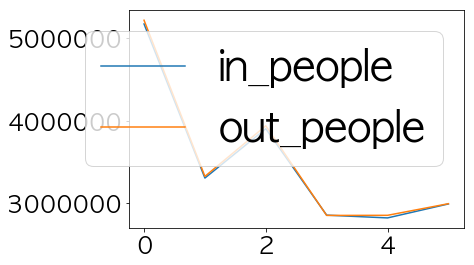

In [124]:
agg_people_per_date = []
for idx, group in subway_people_df.groupby('date'):
    date = idx
    ip_sum = group.in_people.sum()
    op_sum = group.out_people.sum()
    agg_people_per_date.append({
        'date': date, 'in_people': ip_sum, 'out_people': op_sum
    })
agg_people_per_date_df = pd.DataFrame(agg_people_per_date)
# agg_people_per_date_df = agg_people_per_date_df.set_index(agg_people_per_date_df['date'])
print(agg_people_per_date_df)
agg_people_per_date_df.plot()

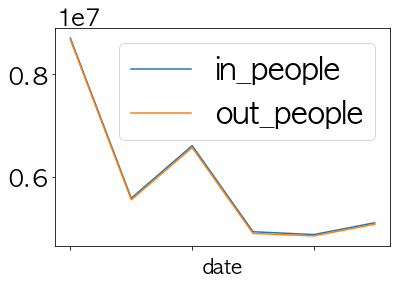

In [113]:
subway_people_org_df = pd.read_csv('./gendata/subway/in_out_by_date.csv')
subway_people_org_df = subway_people_org_df.drop(['Unnamed: 0', 'line'], axis=1)
subway_people_org_df.date = subway_people_org_df.date.apply(str)
c
agg_people_per_date = []
for idx, group in subway_people_org_df.groupby('date'):
    date = idx
    ip_sum = group.in_people.sum()
    op_sum = group.out_people.sum()
    agg_people_per_date.append({
        'date': date, 'in_people': ip_sum, 'out_people': op_sum
    })
agg_people_per_date_df = pd.DataFrame(agg_people_per_date)
agg_people_per_date_df = agg_people_per_date_df.set_index(agg_people_per_date_df.date)
agg_people_per_date_df.plot()

2009-12-24
2009-12-25
2010-12-24
2010-12-25
2011-12-24
2011-12-25
2012-12-24
2012-12-25
2013-12-24
2013-12-25
2014-12-24
2014-12-25
2015-12-24
2015-12-25
2016-12-24
2016-12-25
2017-12-24
2017-12-25


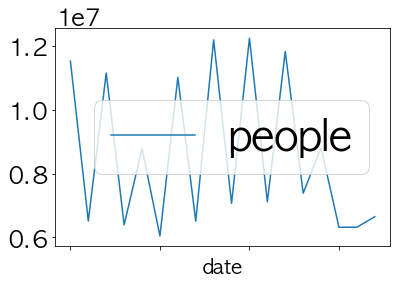

In [169]:
subway_people_by_time_df = pd.read_csv('./gendata/subway/in_out_by_time.csv')
subway_people_by_time_df = subway_people_by_time_df[subway_people_by_time_df['date'].str.match(r'20\d\d-12-2[45]')]
subway_people_by_time_df['people'] = subway_people_by_time_df.drop(['date', 'code', 'type'], axis=1).values.sum(axis=1)

agg_people_per_date = []
for idx, group in subway_people_by_time_df.groupby('date'):
    people_sum = group.people.sum()
    print(idx)
    if '24' in idx:
        agg_people_per_date.append({
            'date': idx[:4], 'people': people_sum, 'event': 'christmas_eve'
        })
    else:
        agg_people_per_date.append({
            'date': idx[:4], 'people': people_sum, 'event': 'christmas'
        })
agg_people_per_date_df = pd.DataFrame(agg_people_per_date)
agg_people_per_date_df = agg_people_per_date_df.set_index(agg_people_per_date_df.date)
agg_people_per_date_df.plot()

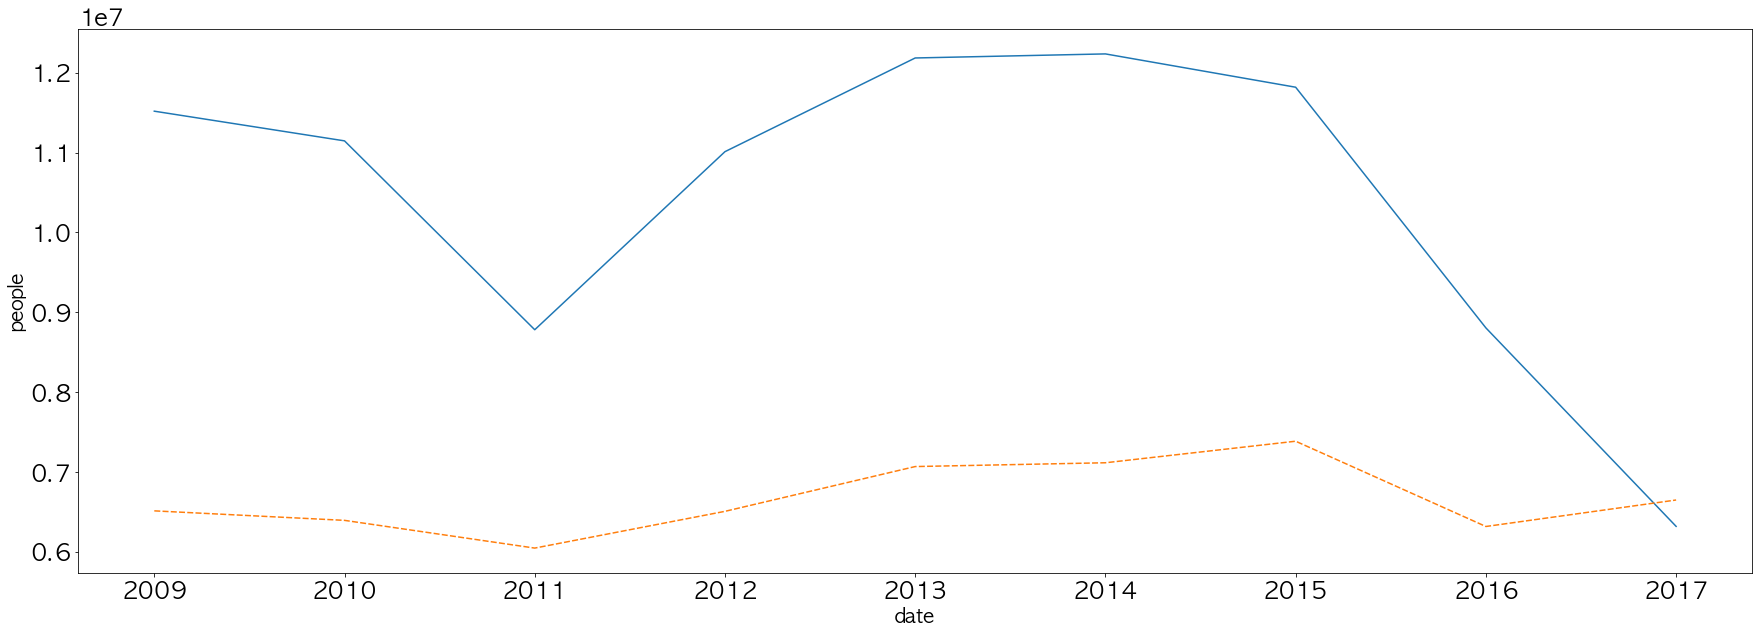

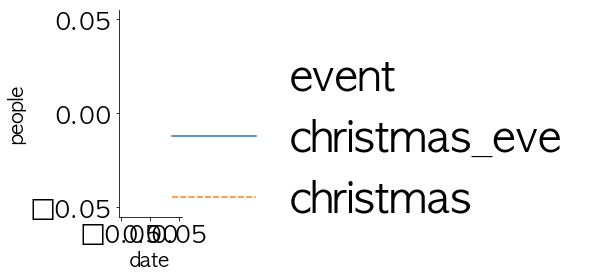

In [170]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.relplot(x="date", y="people", hue="event", style="event", kind="line", data=agg_people_per_date_df, ax=ax)

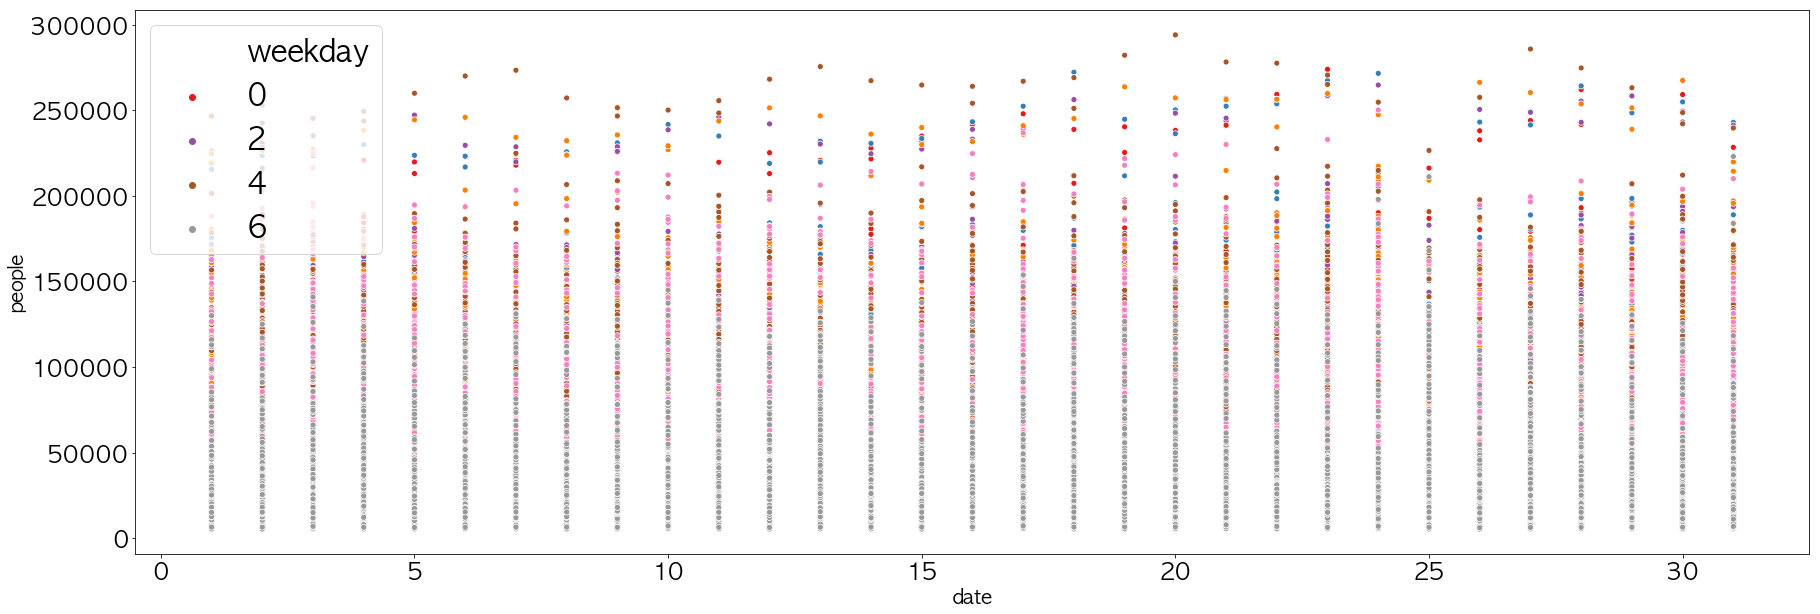

In [321]:
subway_people_by_time_df = pd.read_csv('./gendata/subway/in_out_by_time.csv')
subway_people_by_time_df.date = subway_people_by_time_df.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d"))
subway_people_by_time_df['weekday'] = subway_people_by_time_df.date.apply(lambda d: d.weekday())
subway_people_by_time_df['day'] = subway_people_by_time_df.date.apply(lambda d: d.day)
subway_people_by_time_df['year'] = subway_people_by_time_df.date.apply(lambda d: d.year)
# subway_people_by_time_df = subway_people_by_time_df.query('weekday == 6')
subway_people_by_time_df.head()

subway_people_by_time_df['people'] = subway_people_by_time_df.drop(['date', 'type', 'weekday'], axis=1).values.sum(axis=1)
subway_people_by_time_df.people.mean()

agg_people_per_date = []
for idx, group in subway_people_by_time_df.groupby(['day', 'weekday', 'year', 'code']):
    people_sum = group.people.sum()
    agg_people_per_date.append({
        'date': idx[0], 'people': people_sum, 'weekday': idx[1], 'year': idx[2], 'code': idx[3]
    })
        
agg_people_per_date_df = pd.DataFrame(agg_people_per_date)
agg_people_per_date_df = agg_people_per_date_df.set_index(agg_people_per_date_df.date)
agg_people_per_date_df

fig, ax = plt.subplots(figsize=(30, 10))
sns.scatterplot(x="date", y="people", hue="weekday", data=agg_people_per_date_df, palette="Set1", lw=2)

In [323]:
subway_people_by_time_df = 
# 239

,code,date,people,weekday,year
date,,,,,
1,150,1,147337,0,2014
1,151,1,58908,0,2014
1,152,1,108237,0,2014
1,153,1,76447,0,2014
1,154,1,65408,0,2014
1,155,1,38215,0,2014
1,156,1,42463,0,2014
1,157,1,45678,0,2014
1,158,1,67348,0,2014


In [387]:
subway_people_org_df = pd.read_csv('./gendata/subway/in_out_by_date.csv')
subway_people_org_df = subway_people_org_df.drop(['Unnamed: 0', 'line'], axis=1)
subway_people_org_df.date = subway_people_org_df.date.apply(lambda d: datetime.strptime(str(d), "%Y%m%d"))
subway_people_org_df['weekday'] = subway_people_org_df.date.apply(lambda d: d.weekday())
subway_people_org_df['day'] = subway_people_org_df.date.apply(lambda d: d.day)
subway_people_org_df['year'] = subway_people_org_df.date.apply(lambda d: d.year)

for name, group in subway_people_org_df.groupby(['name', 'date']):
    ip_sum = group.in_people.sum()
    op_sum = group.out_people.sum()
    for idx in group.index:
        subway_people_org_df.at[idx, 'in_people'] = ip_sum
        subway_people_org_df.at[idx, 'out_people'] = op_sum

subway_people_org_df = subway_people_org_df.drop_duplicates(['name', 'date'])
subway_people_org_df.head()

,date,code,name,in_people,out_people,weekday,day,year
0,2015-12-01,4108,증미,8829.0,8857.0,1,1,2015
1,2015-12-01,4109,등촌,12770.0,12646.0,1,1,2015
2,2015-12-01,4110,염창,17803.0,17646.0,1,1,2015
3,2015-12-01,4111,신목동,5052.0,4329.0,1,1,2015
4,2015-12-01,4112,선유도,7997.0,8027.0,1,1,2015


In [388]:
mean_p = {}
agg_people_per_date = []
for idx, group in subway_people_org_df.groupby(['year', 'weekday', 'name']):
    pm = group.in_people.mean() + group.out_people.mean()
    agg_people_per_date.append({
        'year': idx[0], 'weekday': idx[1], 'mean_people': pm, 'name': idx[2]
    })
    mean_p[idx] = pm
agg_people_per_date_df = pd.DataFrame(agg_people_per_date)
# agg_people_per_date_df = agg_people_per_date_df.set_index(agg_people_per_date_df.date)
agg_people_per_date_df

,mean_people,name,weekday,year
0,16546.75,가능,0,2015
1,36699.25,가락시장,0,2015
2,148069.00,가산디지털단지,0,2015
3,44633.00,가양,0,2015
4,8316.75,가좌,0,2015
5,23363.75,가천대,0,2015
6,4614.00,가평,0,2015
7,14999.00,간석,0,2015
8,839.25,갈매,0,2015
9,226341.75,강남,0,2015


In [389]:
# agg_people_per_date_df  # 시각화
# fig, ax = plt.subplots(figsize=(20, 10))
# sns.lineplot(x='year', y='mean_people', hue='weekday', data=agg_people_per_date_df, palette="Set2", lw=3)
mean_p

{(2015, 0, '가능'): 16546.75,
 (2015, 0, '가락시장'): 36699.25,
 (2015, 0, '가산디지털단지'): 148069.0,
 (2015, 0, '가양'): 44633.0,
 (2015, 0, '가좌'): 8316.75,
 (2015, 0, '가천대'): 23363.75,
 (2015, 0, '가평'): 4614.0,
 (2015, 0, '간석'): 14999.0,
 (2015, 0, '갈매'): 839.25,
 (2015, 0, '강남'): 226341.75,
 (2015, 0, '강남구청'): 59179.75,
 (2015, 0, '강동'): 40038.5,
 (2015, 0, '강동구청'): 25053.75,
 (2015, 0, '강매'): 5122.5,
 (2015, 0, '강변'): 102352.75,
 (2015, 0, '강촌'): 1258.25,
 (2015, 0, '개롱'): 16668.0,
 (2015, 0, '개봉'): 49742.25,
 (2015, 0, '개포동'): 8298.25,
 (2015, 0, '개화'): 12378.5,
 (2015, 0, '개화산'): 13227.0,
 (2015, 0, '거여'): 16255.0,
 (2015, 0, '건대입구'): 133399.0,
 (2015, 0, '검암'): 34973.5,
 (2015, 0, '경마공원'): 2225.5,
 (2015, 0, '경복궁'): 53159.5,
 (2015, 0, '경찰병원'): 18330.0,
 (2015, 0, '계양'): 22480.75,
 (2015, 0, '고덕'): 19645.0,
 (2015, 0, '고려대'): 22513.0,
 (2015, 0, '고속터미널'): 186195.75,
 (2015, 0, '고잔'): 19666.0,
 (2015, 0, '곡산'): 1127.75,
 (2015, 0, '공덕'): 83907.5,
 (2015, 0, '공릉'): 28685.0,
 (2015, 0, '공항시장'):

In [390]:
subway_people_christ_df = subway_people_org_df.query('day == 24 or day == 25')
subway_people_christ_df['people'] = subway_people_christ_df.apply(lambda r: r['in_people'] + r['out_people'], axis=1)

/Users/ShinAhnjae/anaconda3/envs/data_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [391]:
for idx, row in subway_people_christ_df.iterrows():
    people = row['people']
    year = row['year']
    name = row['name']
    weekday = row['weekday']
    mean_people = mean_p[(year, weekday, name)]
    people = people - mean_people
    subway_people_christ_df.at[idx, 'diff'] = people
    subway_people_christ_df.at[idx, 'mean'] = mean_people

/Users/ShinAhnjae/anaconda3/envs/data_py3.6/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ShinAhnjae/anaconda3/envs/data_py3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [392]:
subway_people_christ_df = subway_people_christ_df.drop(['in_people', 'out_people'], axis=1)
subway_people_christ_df.to_csv('./gendata/subway/diff.csv')
subway_people_christ_df

,date,code,name,weekday,day,year,people,diff,mean
12604,2015-12-24,4209,검암,3,24,2015,37954.0,1588.00,36366.00
12605,2015-12-24,4210,청라국제도시,3,24,2015,10545.0,-14.40,10559.40
12606,2015-12-24,4211,운서,3,24,2015,13011.0,566.20,12444.80
12607,2015-12-24,4212,공항화물청사,3,24,2015,5849.0,43.20,5805.80
12608,2015-12-24,4213,인천국제공항,3,24,2015,27013.0,2824.00,24189.00
12609,2015-12-24,4126,언주,3,24,2015,18088.0,1035.40,17052.60
12610,2015-12-24,4127,선정릉,3,24,2015,33971.0,530.00,33441.00
12611,2015-12-24,4128,삼성중앙,3,24,2015,11073.0,99.40,10973.60
12612,2015-12-24,4129,봉은사,3,24,2015,25662.0,-545.20,26207.20
12613,2015-12-24,4130,종합운동장,3,24,2015,47728.0,1240.40,46487.60


In [393]:
subway_people_christ_top_df = subway_people_christ_df[subway_people_christ_df['diff'] != 0].sort_values('diff', ascending=False)
print(len(subway_people_christ_top_df))

subway_people_christ_top_df.head()

2942


,date,code,name,weekday,day,year,people,diff,mean
48472,2017-12-25,239,홍대입구,0,25,2017,236577.0,53270.25,183306.75
30557,2016-12-25,239,홍대입구,6,25,2016,231161.0,52586.50,178574.50
13408,2015-12-25,424,명동,4,25,2015,158573.0,46238.75,112334.25
12666,2015-12-24,4203,홍대입구,3,24,2015,236772.0,44301.60,192470.40
12661,2015-12-24,4123,고속터미널,3,24,2015,245647.0,37818.40,207828.60


In [455]:
subway_people_christ_top_df['ratio'] = subway_people_christ_top_df.apply(lambda r: r['mean'] / r['people'], axis=1)
subway_people_christ_top_df[subway_people_christ_top_df.people > 150000].sort_values('ratio', ascending=False)

,date,code,name,weekday,day,year,people,diff,mean,ratio
13326,2015-12-25,4201,서울역,4,25,2015,159720.0,-41933.25,201653.25,1.262542
48424,2017-12-25,150,서울역,0,25,2017,152129.0,-24972.75,177101.75,1.164155
13323,2015-12-25,4123,고속터미널,4,25,2015,187226.0,-27049.50,214275.50,1.144475
29980,2016-12-24,151,시청,5,24,2016,154217.0,-13658.60,167875.60,1.088567
30010,2016-12-24,222,강남,5,24,2016,168564.0,-11957.00,180521.00,1.070934
29979,2016-12-24,150,서울역,5,24,2016,170403.0,-11122.20,181525.20,1.065270
30068,2016-12-24,329,고속터미널,5,24,2016,234090.0,-12611.00,246701.00,1.053872
30705,2016-12-25,329,고속터미널,6,25,2016,182853.0,-8792.25,191645.25,1.048084
13036,2015-12-24,433,사당,3,24,2015,169380.0,-4169.80,173549.80,1.024618
48449,2017-12-25,216,잠실(송파구청),0,25,2017,219428.0,-3038.75,222466.75,1.013849


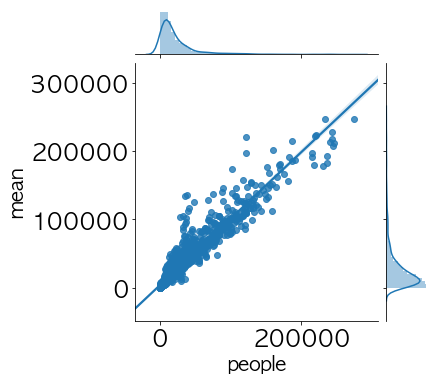

In [400]:
sns.jointplot(x="people", y="mean", data=subway_people_christ_top_df, kind="reg")

In [401]:
subway_people_by_time_df = pd.read_csv('./gendata/subway/in_out_by_time.csv')
subway_people_by_time_df.date = subway_people_by_time_df.date.apply(lambda d: datetime.strptime(d, "%Y-%m-%d"))
subway_people_by_time_df['weekday'] = subway_people_by_time_df.date.apply(lambda d: d.weekday())
subway_people_by_time_df['day'] = subway_people_by_time_df.date.apply(lambda d: d.day)
subway_people_by_time_df['year'] = subway_people_by_time_df.date.apply(lambda d: d.year)
# subway_people_by_time_df = subway_people_by_time_df.query('weekday == 6')
subway_people_by_time_df.head()

,date,code,type,05~06,06~07,07~08,08~09,09~10,10-11,11~12,...,18~19,19~20,20~21,21~22,22~23,23~24,24~,weekday,day,year
0,2009-12-01,150,승차,522,725,1680,3644,2438,2439,2318,...,7672,5188,3008,2945,2272,1210,186,1,1,2009
1,2009-12-01,150,하차,278,1249,3452,8978,5005,2286,2216,...,3214,2361,1830,1710,1641,784,370,1,1,2009
2,2009-12-01,151,승차,59,113,225,349,394,642,1066,...,4882,3067,2067,2246,1845,566,65,1,1,2009
3,2009-12-01,151,하차,141,604,2678,7537,3961,1344,1415,...,1084,841,291,288,231,110,61,1,1,2009
4,2009-12-01,152,승차,132,228,584,906,839,1088,1578,...,7403,5142,4256,5339,4791,1935,212,1,1,2009


In [402]:
subway_people_by_time_df = subway_people_by_time_df.set_index(subway_people_by_time_df.code)

In [444]:
subway_hongdae_df = subway_people_by_time_df.loc[336]
subway_hongdae_df = subway_hongdae_df.query('day in (1, 2, 3)')
subway_hongdae_df = subway_hongdae_df.query('year in (2014, 2015, 2016, 2017)')
subway_hongdae_df.head()

,date,code,type,05~06,06~07,07~08,08~09,09~10,10-11,11~12,...,18~19,19~20,20~21,21~22,22~23,23~24,24~,weekday,day,year
code,,,,,,,,,,,,,,,,,,,,,
336,2014-12-01,336,승차,21,74,260,246,141,99,99,...,232,179,98,157,139,22,5,0,1,2014
336,2014-12-01,336,하차,14,62,147,349,220,126,199,...,246,248,152,106,97,78,23,0,1,2014
336,2014-12-02,336,승차,13,65,233,266,164,82,89,...,283,148,116,180,118,23,3,1,2,2014
336,2014-12-02,336,하차,9,54,143,334,172,90,174,...,215,223,124,116,121,75,26,1,2,2014
336,2014-12-03,336,승차,20,70,219,266,158,93,115,...,295,156,154,241,118,29,6,2,3,2014


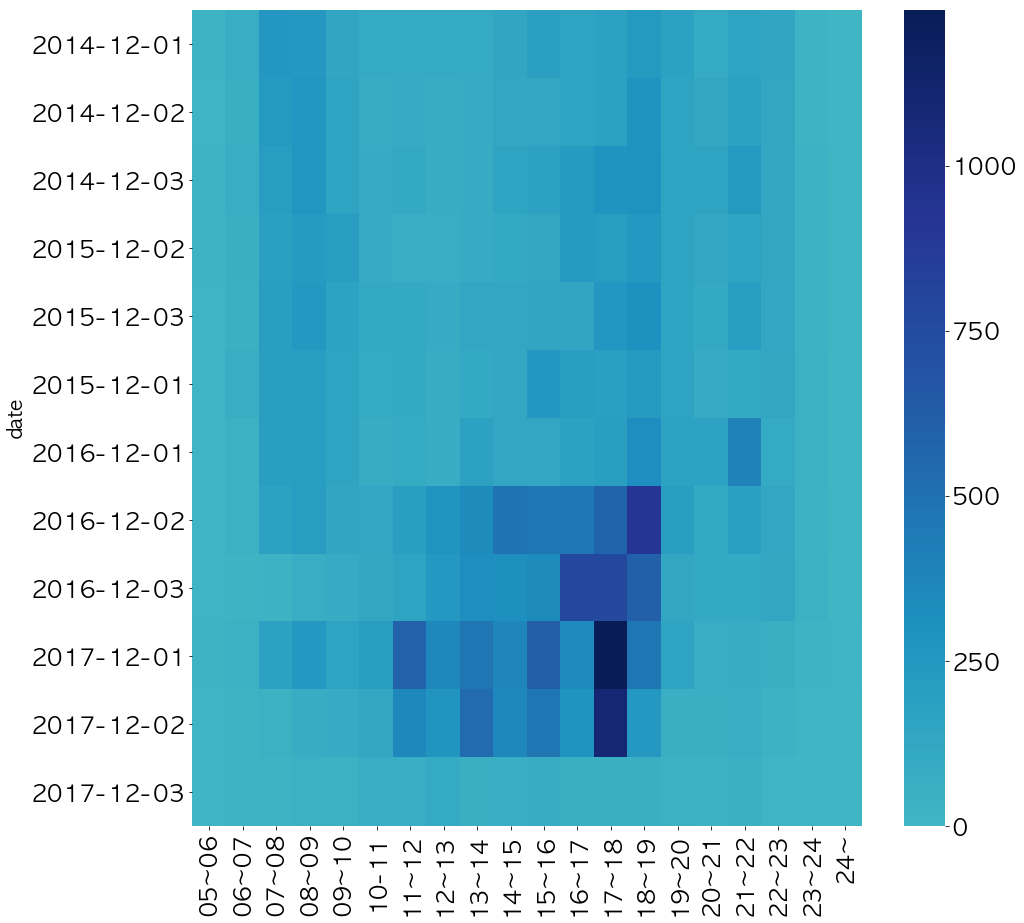

In [445]:
fig, ax = plt.subplots(figsize=(15, 15))
hongdae_df = subway_hongdae_df[subway_hongdae_df['type'] == '승차']

hongdae_df = hongdae_df.drop(['date', 'code', 'type', 'weekday', 'day', 'year'], axis=1)
hongdae_df = hongdae_df.set_index(subway_hongdae_df[subway_hongdae_df['type'] == '승차'].date.apply(lambda d: d.strftime("%Y-%m-%d")))
sns.heatmap(hongdae_df, center=0, cmap="YlGnBu")

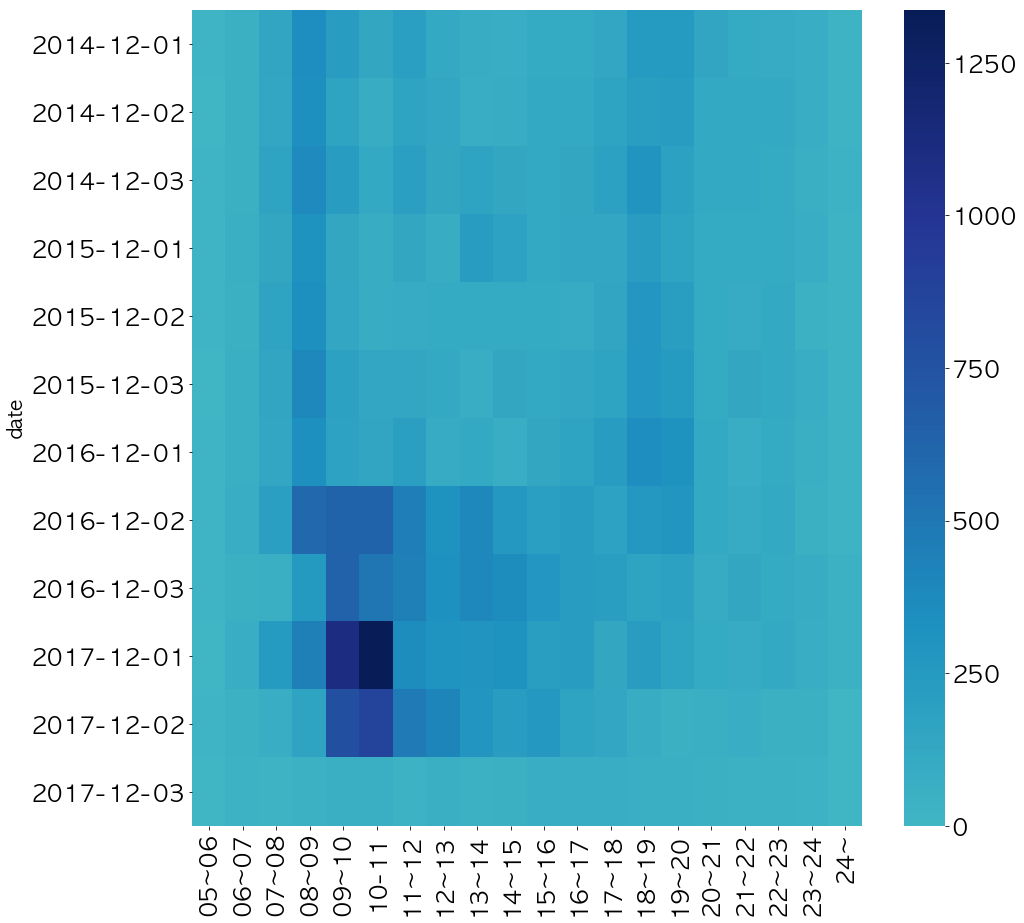

In [446]:
fig, ax = plt.subplots(figsize=(15, 15))
hongdae_df = subway_hongdae_df[subway_hongdae_df['type'] == '하차']

hongdae_df = hongdae_df.drop(['date', 'code', 'type', 'weekday', 'day', 'year'], axis=1)
hongdae_df = hongdae_df.set_index(subway_hongdae_df[subway_hongdae_df['type'] == '하차'].date.apply(lambda d: d.strftime("%Y-%m-%d")))
sns.heatmap(hongdae_df, center=0, cmap="YlGnBu")